In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import dipy.sims.voxel as vox

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
def akaike(sse, n_observations, n_params):
    return n_observations * np.log(sse / n_observations) + 2 * n_params 

In [5]:
def akaike_c(sse, n_observations, n_params): 
    return (akaike(sse, n_observations, n_params) + 
            (2 * n_params**2 + 2*n_params) / 
            (n_observations - n_params - 1))

In [6]:
def ground_truth(b):
    return 0.8 * np.exp(-1.2 * b) + 0.2 * np.exp(-0.2 * b)    

In [7]:
def bi_exponential(b, beta1, d1, beta2, d2):
    return beta1 * np.exp(d1 * b) + beta2 * np.exp(d2 * b)

In [8]:
def cumulant_expansion(b, S0, d, k):
    return S0 * np.exp(-b*d + k*(b**2))

In [9]:
def stretched_exponential(b, S0, d, alpha):
    return S0 * np.exp(-((b * d)**alpha))

In [10]:
b = np.array([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5])

In [11]:
from scipy.optimize import curve_fit

In [12]:
n_sims = 10000
snr = np.array([2000, 200, 20])
models = np.array([[bi_exponential, 4],
                   [cumulant_expansion, 3], 
                   [stretched_exponential, 3]])

fits = np.zeros((models.shape[0], snr.shape[0], n_sims, b.shape[0]))
sims = np.zeros([snr.shape[0], n_sims, 2, b.shape[0]])

rmse = np.zeros((models.shape[0], snr.shape[0], n_sims))
rrmse = np.zeros((models.shape[0], snr.shape[0], n_sims))

aicc = np.zeros((models.shape[0], snr.shape[0], n_sims))
test_retest = np.zeros((snr.shape[0], n_sims))

for ii, s in enumerate(snr):
    for jj in range(n_sims):
        sig1 = vox.add_noise(ground_truth(b), s, 1, 
                             noise_type="rayleigh")

        sig2 = vox.add_noise(ground_truth(b), s, 1, 
                             noise_type="rayleigh")
    
        sims[ii, jj] = np.array([sig1, sig2])
        test_retest[ii, jj] = np.sqrt(np.mean((sig1 - sig2)**2))
        for mm, model in enumerate(models):
            params, cov  = curve_fit(model[0], b, sig1, 
                                     p0=np.ones(model[1]) * 0.5, 
                                     maxfev=100000)
            fit = model[0](b, *params)
            rmse[mm, ii, jj] = np.sqrt(np.mean((fit - sig2)**2))
            fits[mm, ii, jj] = fit
            rrmse[mm, ii, jj] = rmse[mm, ii, jj] / test_retest[ii, jj]
            
            # AIC computed within sample:
            sse = np.sum((fit - sig1) ** 2)
            aicc[mm, ii, jj] = akaike_c(sse, b.shape[0], model[1])

/Users/arokem/.virtualenvs/ismrm_diffusion/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/Users/arokem/.virtualenvs/ismrm_diffusion/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


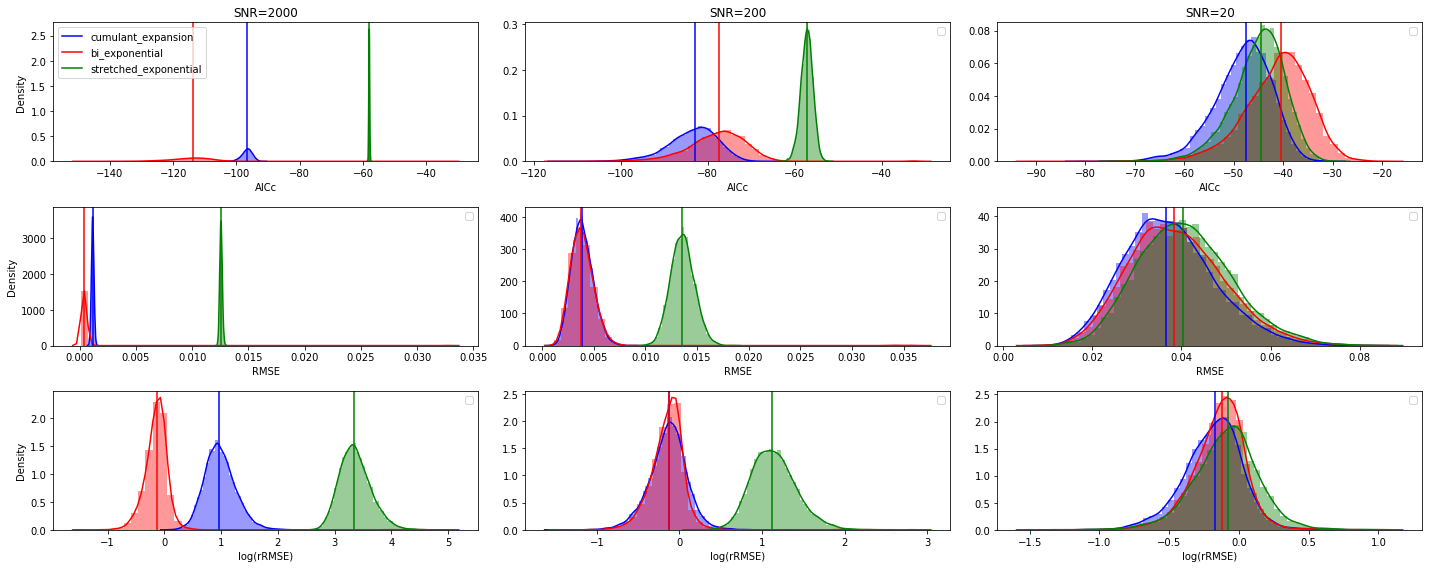

In [13]:
fig, ax = plt.subplots(3, 3)
for ii, data in enumerate([aicc, rmse, np.log(rrmse)]):
    for jj, s in enumerate(snr):
        df = pd.DataFrame(data = data[:, jj].T, 
                          columns=[f[0].__name__ for f in models])

        sns.distplot(df['cumulant_expansion'], ax=ax[ii, jj], color='b')
        sns.distplot(df['bi_exponential'], ax=ax[ii, jj], color='r')
        sns.distplot(df['stretched_exponential'], ax=ax[ii, jj], color='g')

        ax[ii, jj].axvline(np.median(df['cumulant_expansion']), color='b', label='cumulant_expansion')
        ax[ii, jj].axvline(np.median(df['bi_exponential']), color='r', label='bi_exponential') 
        ax[ii, jj].axvline(np.median(df['stretched_exponential']), color='g', label='stretched_exponential')
        if ii > 0 or jj > 0: 
            ax[ii, jj].legend([])
        if ii == 0:
            ax[ii, jj].set_title("SNR=%s"%s)

fig.set_size_inches([20, 8])  
ax[0, 0].legend()

for a in ax[0]:
    a.set_xlabel('AICc')
for a in ax[1]:
    a.set_xlabel("RMSE")
for a in ax[2]:
    a.set_xlabel("log(rRMSE)")
for a in ax[:, 0]:
    a.set_ylabel("Density")
    
fig.tight_layout()